In [2]:
import pandas as pd
import zipfile
import os

# Step 1 - Set the dataset location
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
extract_path = os.path.join(dataset_path, 'train_extracted')

# Step 2 - Extract
if not os.path.exists(extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Train data extracted successfully.")
else:
    print("Train data already extracted.")

# Step 3 - Find CSVs (even if they are inside subfolders)
csv_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found CSV files: {csv_files}")

# Step 4 - Load CSVs
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')  # tag experiment ID
    dataframes.append(df)

# Step 5 - Concatenate
if dataframes:
    full_train_data = pd.concat(dataframes, ignore_index=True)
    print(f"Total shape of combined train dataset: {full_train_data.shape}")
    print(full_train_data.head())
else:
    print("No CSV files found.")


Train data extracted successfully.
Found CSV files: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_1.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_20.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_21.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_23.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_24.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_9.csv']
Total shape of combined train dataset: (52940, 4)
        time  input_voltage     el_power experiment
0  810.07028           10.0  1228.791720       ex_1
1  811.06938           10.0  1223.041745       ex_1
2  812.06848           10.0  1244.960866       ex_1
3  813.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Make a copy to avoid altering original
df = full_train_data.copy()

# Normalize input_voltage and el_power
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

df['input_voltage_norm'] = scaler_input.fit_transform(df[['input_voltage']])
df['el_power_norm'] = scaler_output.fit_transform(df[['el_power']])

# Detect transitions based on sudden change in input voltage
df['delta_input'] = df['input_voltage_norm'].diff().abs()
transition_threshold = 0.05
df['is_transition'] = df['delta_input'] > transition_threshold

# Show transition distribution per experiment
transition_summary = df.groupby('experiment')['is_transition'].sum().reset_index()
print("Number of transitions per experiment:")
print(transition_summary)

# Save preprocessed dataframe for next steps
preprocessed_df = df.copy()

Number of transitions per experiment:
  experiment  is_transition
0       ex_1              3
1      ex_20              6
2      ex_21              6
3      ex_23             76
4      ex_24             76
5       ex_9              8


PyTorch version: 2.7.1+cpu


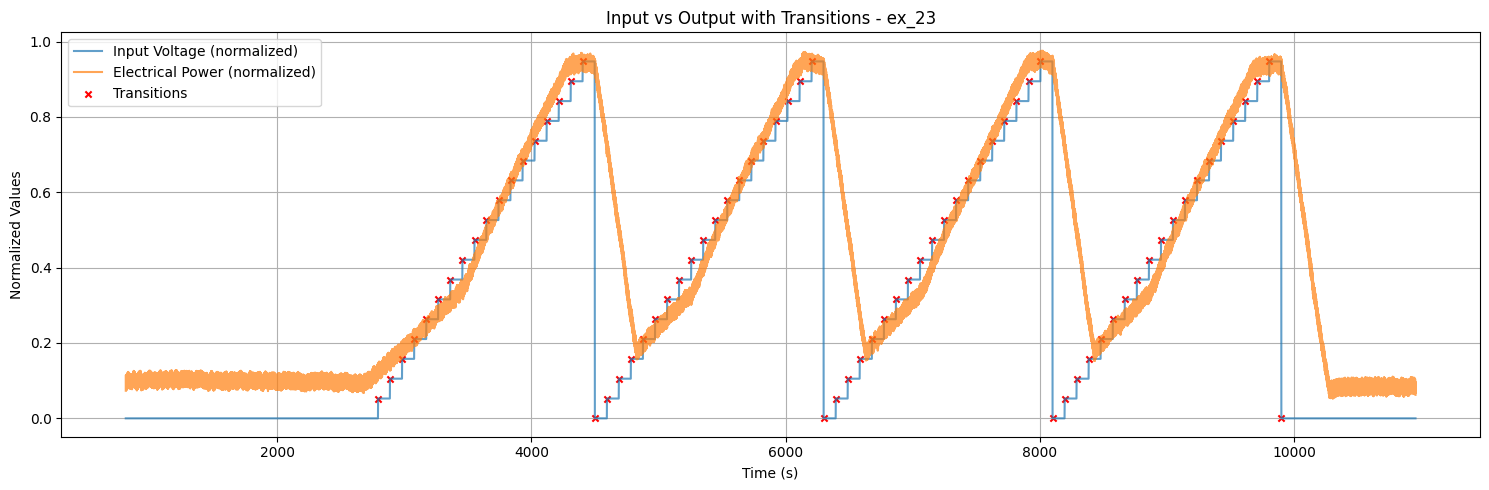

In [4]:
# Check if PyTorch is installed
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch is NOT installed. Please install it before proceeding.")

# Let's plot one experiment to visualize transitions
import matplotlib.pyplot as plt

# Choose experiment with rich transitions
exp_to_plot = 'ex_23'
df_plot = preprocessed_df[preprocessed_df['experiment'] == exp_to_plot].copy()

# Plot normalized input and output with transition markers
plt.figure(figsize=(15, 5))
plt.plot(df_plot['time'], df_plot['input_voltage_norm'], label='Input Voltage (normalized)', alpha=0.7)
plt.plot(df_plot['time'], df_plot['el_power_norm'], label='Electrical Power (normalized)', alpha=0.7)
plt.scatter(df_plot['time'][df_plot['is_transition']], 
            df_plot['input_voltage_norm'][df_plot['is_transition']], 
            color='red', label='Transitions', marker='x', s=20)

plt.title(f"Input vs Output with Transitions - {exp_to_plot}")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Create sequences
def create_sequences(df, input_col='input_voltage_norm', target_col='el_power_norm', seq_len=60):
    X, y = [], []
    for i in range(len(df) - seq_len):
        x_seq = df[input_col].iloc[i:i+seq_len].values
        y_val = df[target_col].iloc[i+seq_len]
        X.append(x_seq)
        y.append(y_val)
    return np.array(X), np.array(y)

# Use only one experiment for now (you can extend later)
selected_exp = 'ex_23'
exp_df = preprocessed_df[preprocessed_df['experiment'] == selected_exp].reset_index(drop=True)

sequence_length = 60
X, y = create_sequences(exp_df, seq_len=sequence_length)
print(f"Shape of X: {X.shape}, y: {y.shape}")

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")


Shape of X: (9128, 60), y: (9128,)
Train: (7302, 60), Val: (1826, 60)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Dataset class
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add feature dim
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
batch_size = 64

train_dataset = TurbineDataset(X_train, y_train)
val_dataset = TurbineDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last time step output
        out = self.fc(out)
        return out.squeeze()

# Initialize model
model = LSTMRegressor()
print(model)


LSTMRegressor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch 1/30 | Train Loss: 0.04346 | Val Loss: 0.03024
Epoch 2/30 | Train Loss: 0.02042 | Val Loss: 0.02400
Epoch 3/30 | Train Loss: 0.01939 | Val Loss: 0.03882
Epoch 4/30 | Train Loss: 0.01745 | Val Loss: 0.02270
Epoch 5/30 | Train Loss: 0.02107 | Val Loss: 0.02347
Epoch 6/30 | Train Loss: 0.01620 | Val Loss: 0.02282
Epoch 7/30 | Train Loss: 0.01528 | Val Loss: 0.02397
Epoch 8/30 | Train Loss: 0.01518 | Val Loss: 0.02086
Epoch 9/30 | Train Loss: 0.01464 | Val Loss: 0.02110
Epoch 10/30 | Train Loss: 0.01467 | Val Loss: 0.02115
Epoch 11/30 | Train Loss: 0.01480 | Val Loss: 0.02109
Epoch 12/30 | Train Loss: 0.01482 | Val Loss: 0.02162
Epoch 13/30 | Train Loss: 0.01495 | Val Loss: 0.02154
Epoch 14/30 | Train Loss: 0.01486 | Val Loss: 0.02145
Epoch 15/30 | Train Loss: 0.01492 | Val Loss: 0.02145
Epoch 16/30 | Train Loss: 0.01480 | Val Loss: 0.02130
Epoch 17/30 | Train Loss: 0.01475 | Val Loss: 0.02182
Epoch 18/30 | Train Loss: 0.01477 | Val Loss: 0.02134
Epoch 19/30 | Train Loss: 0.01472 | V

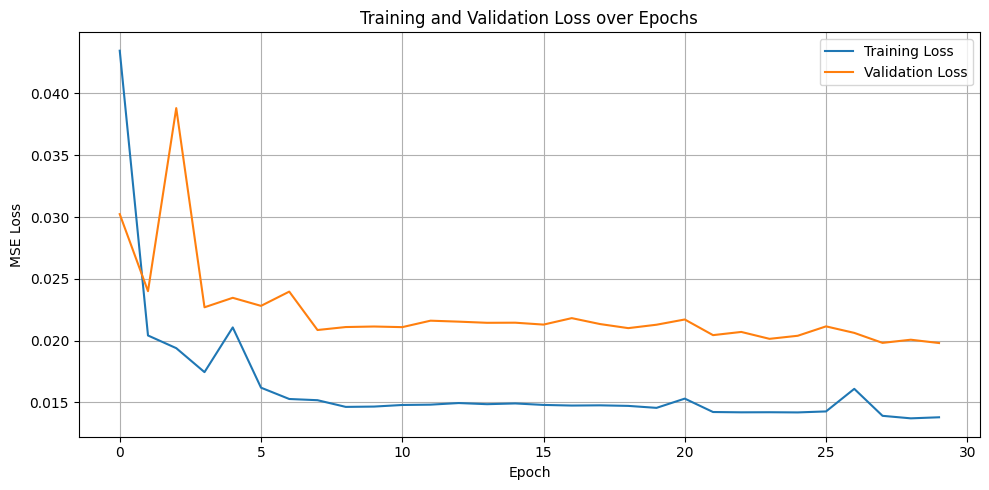

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


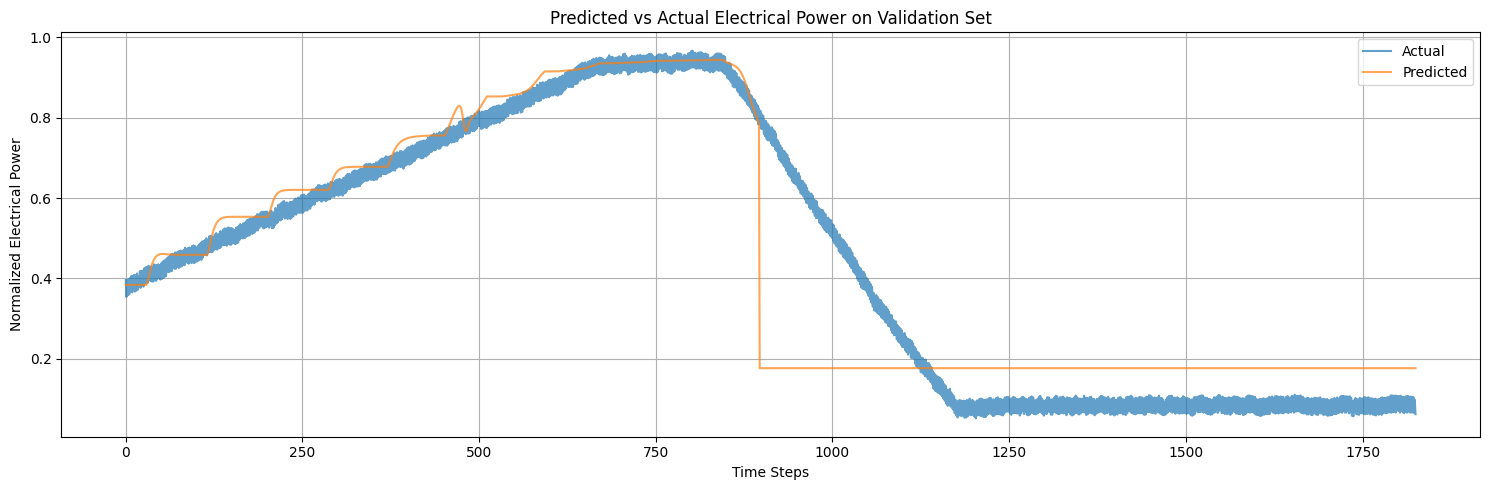

In [8]:
# Evaluate model on validation set
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

# Plot predicted vs actual
plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual', alpha=0.7)
plt.plot(preds, label='Predicted', alpha=0.7)
plt.title("Predicted vs Actual Electrical Power on Validation Set")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Electrical Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Filter transition vs stationary
transition_mask = val_result_df['is_transition']
stationary_mask = ~val_result_df['is_transition']

# Compute RMSE manually using sqrt of MSE
mse_trans = mean_squared_error(
    val_result_df['actual_power'][transition_mask],
    val_result_df['predicted_power'][transition_mask]
)
rmse_trans = np.sqrt(mse_trans)

mse_stationary = mean_squared_error(
    val_result_df['actual_power'][stationary_mask],
    val_result_df['predicted_power'][stationary_mask]
)
rmse_stationary = np.sqrt(mse_stationary)

print(f"RMSE during transitions     : {rmse_trans:.5f}")
print(f"RMSE during stationary phases: {rmse_stationary:.5f}")


✅ RMSE during transitions     : 0.03136
✅ RMSE during stationary phases: 0.14115


c:\Users\Admin\Documents\MLE\turbine_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


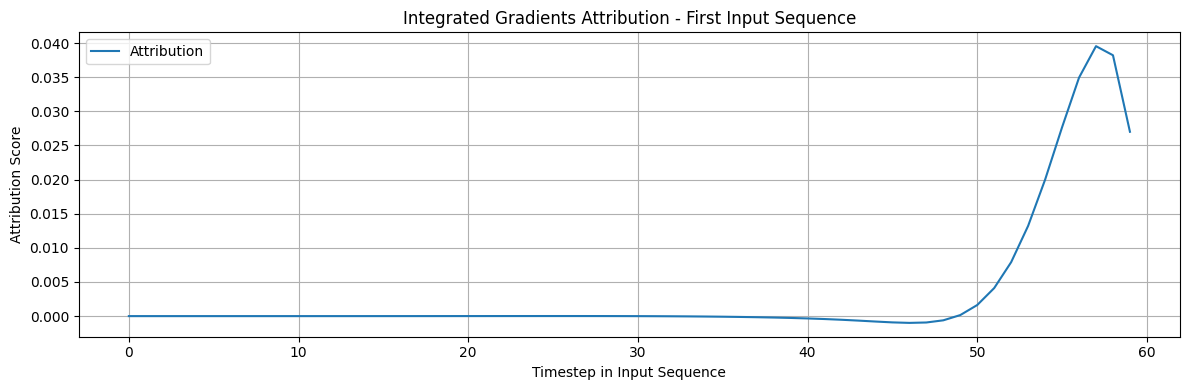

In [14]:
from captum.attr import IntegratedGradients
import torch.nn.functional as F

# Pick a batch of validation data
sample_X, sample_y = next(iter(val_loader))
sample_X = sample_X.to(device)
sample_X.requires_grad_()  # Enable gradients

# Forward hook
def model_forward(input_seq):
    return model(input_seq)

# Captum Integrated Gradients
ig = IntegratedGradients(model_forward)
attr, delta = ig.attribute(inputs=sample_X, target=None, return_convergence_delta=True)

# Convert to CPU and numpy for plotting
attr = attr.cpu().detach().numpy()

# Plot attribution for first sample in batch
plt.figure(figsize=(12, 4))
plt.plot(attr[0].squeeze(), label="Attribution")
plt.title("Integrated Gradients Attribution - First Input Sequence")
plt.xlabel("Timestep in Input Sequence")
plt.ylabel("Attribution Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save trained model
model_path = "lstm_turbine_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

✅ Model saved to lstm_turbine_model.pth


In [16]:
# Extract test.zip
test_zip_path = os.path.join(dataset_path, 'test.zip')
test_extract_path = os.path.join(dataset_path, 'test_extracted')

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)
    print("Test data extracted.")
else:
    print("Test data already extracted.")

Test data extracted.


In [17]:
# Load test CSVs
test_csvs = []
for root, dirs, files in os.walk(test_extract_path):
    for file in files:
        if file.endswith('.csv'):
            test_csvs.append(os.path.join(root, file))

In [18]:
# Load and preprocess one test experiment for now
test_dataframes = []
for file in test_csvs:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    test_dataframes.append(df)

test_df = pd.concat(test_dataframes, ignore_index=True)

In [19]:
# Normalize using the same scaler
test_df['input_voltage_norm'] = scaler_input.transform(test_df[['input_voltage']])
test_df['el_power_norm'] = scaler_output.transform(test_df[['el_power']])

In [20]:
# Create sequences
X_test_seq, y_test_seq = create_sequences(test_df, seq_len=60)


In [21]:
# Predict
model.eval()
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).unsqueeze(-1).to(device)
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()


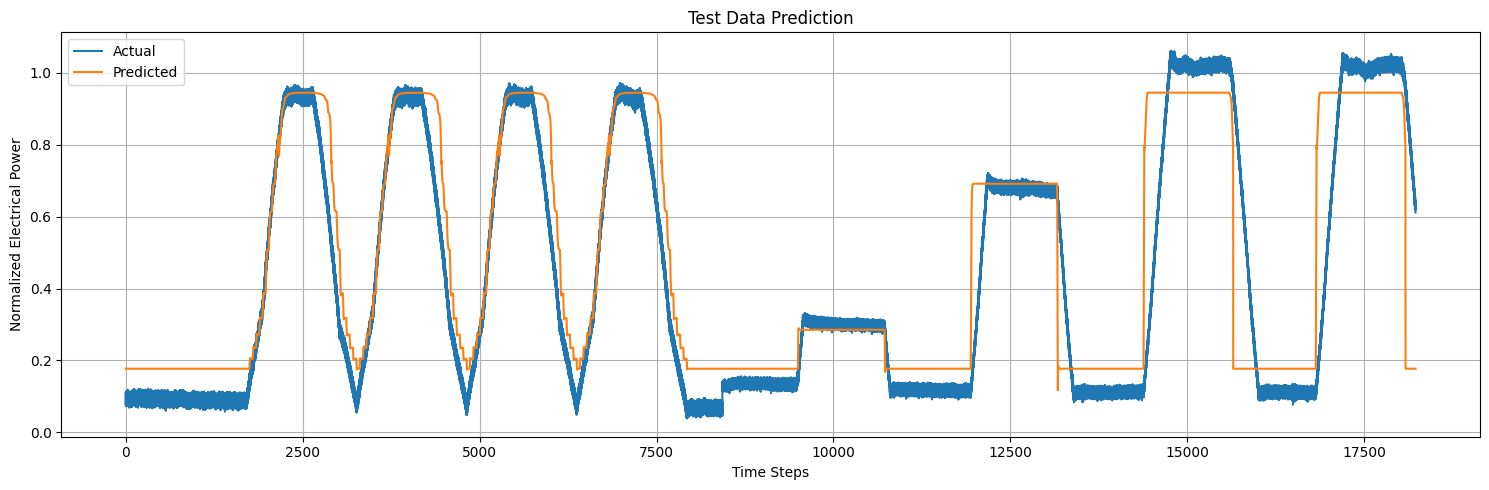

In [22]:
# Plot test prediction
plt.figure(figsize=(15, 5))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Test Data Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Electrical Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
print(f"Test RMSE: {test_rmse:.5f}")


✅ Test RMSE: 0.15387


Ablation 1: No Transition

Epoch 1: Train Loss=0.04032, Val Loss=0.03277
Epoch 2: Train Loss=0.02236, Val Loss=0.02749
Epoch 3: Train Loss=0.02317, Val Loss=0.02538
Epoch 4: Train Loss=0.01837, Val Loss=0.02588
Epoch 5: Train Loss=0.01867, Val Loss=0.02581
Epoch 6: Train Loss=0.01838, Val Loss=0.02667
Epoch 7: Train Loss=0.01835, Val Loss=0.02697
Epoch 8: Train Loss=0.02666, Val Loss=0.03432
Epoch 9: Train Loss=0.02676, Val Loss=0.03112
Epoch 10: Train Loss=0.01877, Val Loss=0.02425
Epoch 11: Train Loss=0.02100, Val Loss=0.03256
Epoch 12: Train Loss=0.02308, Val Loss=0.03444
Epoch 13: Train Loss=0.02393, Val Loss=0.03033
Epoch 14: Train Loss=0.01707, Val Loss=0.02359
Epoch 15: Train Loss=0.02351, Val Loss=0.02260
Epoch 16: Train Loss=0.01558, Val Loss=0.02198
Epoch 17: Train Loss=0.01544, Val Loss=0.02234
Epoch 18: Train Loss=0.01712, Val Loss=0.02249
Epoch 19: Train Loss=0.01566, Val Loss=0.02328
Epoch 20: Train Loss=0.01522, Val Loss=0.02172
Epoch 21: Train Loss=0.01501, Val Loss=0.02185
Epoch 22: Train Loss=0

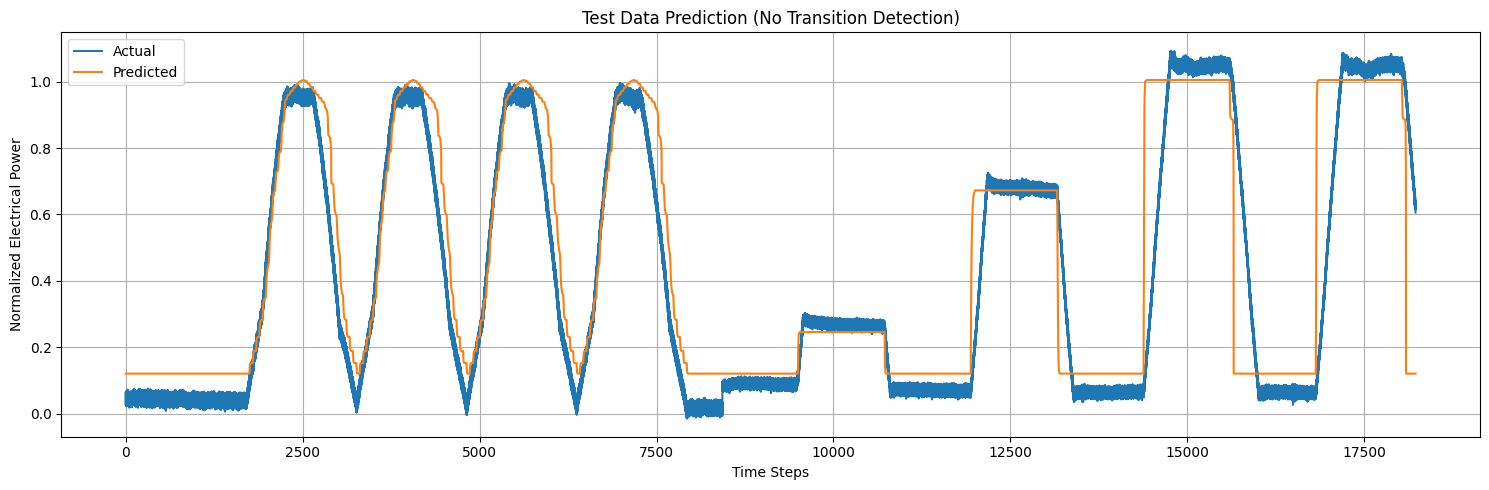

In [ ]:
# Ablation Study: Remove Transition Detection
# File: no_transitions.ipynb (or .py if using script)

import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------------------
# Step 1: Load and preprocess train data
# --------------------------------------
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
train_extract_path = os.path.join(dataset_path, 'train_extracted')

if not os.path.exists(train_extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)

# Load train CSVs
csv_files = [os.path.join(root, file)
             for root, _, files in os.walk(train_extract_path)
             for file in files if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    dataframes.append(df)

train_df = pd.concat(dataframes, ignore_index=True)

# Use one experiment for training (e.g., ex_23)
exp_df = train_df[train_df['experiment'] == 'ex_23'].copy()

# Normalize features
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()
exp_df['input_voltage_norm'] = scaler_input.fit_transform(exp_df[['input_voltage']])
exp_df['el_power_norm'] = scaler_output.fit_transform(exp_df[['el_power']])

# NO TRANSITION DETECTION USED HERE!

# Sequence generator
def create_sequences(df, input_col='input_voltage_norm', target_col='el_power_norm', seq_len=60):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[input_col].iloc[i:i+seq_len].values)
        y.append(df[target_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(exp_df, seq_len=sequence_length)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# --------------------------------------
# Step 2: Define Dataset and LSTM Model
# --------------------------------------
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TurbineDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TurbineDataset(X_val, y_val), batch_size=64, shuffle=False)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

model = LSTMRegressor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------------------
# Step 3: Train model
# --------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.5f}, Val Loss={val_losses[-1]:.5f}")

# --------------------------------------
# Step 4: Load and evaluate on test set
# --------------------------------------
test_zip_path = os.path.join(dataset_path, 'test.zip')
test_extract_path = os.path.join(dataset_path, 'test_extracted')

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)

test_csv_files = [os.path.join(root, file)
                  for root, _, files in os.walk(test_extract_path)
                  for file in files if file.endswith('.csv')]

test_dfs = []
for file in test_csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)
test_df['input_voltage_norm'] = scaler_input.transform(test_df[['input_voltage']])
test_df['el_power_norm'] = scaler_output.transform(test_df[['el_power']])

X_test, y_test = create_sequences(test_df)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE (No Transition Detection): {rmse_test:.5f}")

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Test Data Prediction (No Transition Detection)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Electrical Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ablation 2: Shorter Sequence Length

Epoch 1: Train Loss=0.05321, Val Loss=0.03371
Epoch 2: Train Loss=0.02348, Val Loss=0.03231
Epoch 3: Train Loss=0.02345, Val Loss=0.03646
Epoch 4: Train Loss=0.02297, Val Loss=0.03165
Epoch 5: Train Loss=0.02258, Val Loss=0.03163
Epoch 6: Train Loss=0.02221, Val Loss=0.03074
Epoch 7: Train Loss=0.02210, Val Loss=0.03051
Epoch 8: Train Loss=0.02181, Val Loss=0.03031
Epoch 9: Train Loss=0.02159, Val Loss=0.02993
Epoch 10: Train Loss=0.02179, Val Loss=0.03112
Epoch 11: Train Loss=0.02135, Val Loss=0.02977
Epoch 12: Train Loss=0.02166, Val Loss=0.03015
Epoch 13: Train Loss=0.02097, Val Loss=0.02986
Epoch 14: Train Loss=0.02095, Val Loss=0.02939
Epoch 15: Train Loss=0.02100, Val Loss=0.03006
Epoch 16: Train Loss=0.02088, Val Loss=0.02955
Epoch 17: Train Loss=0.02081, Val Loss=0.02931
Epoch 18: Train Loss=0.02053, Val Loss=0.02902
Epoch 19: Train Loss=0.02057, Val Loss=0.02912
Epoch 20: Train Loss=0.02052, Val Loss=0.02931
Epoch 21: Train Loss=0.02031, Val Loss=0.02900
Epoch 22: Train Loss=0

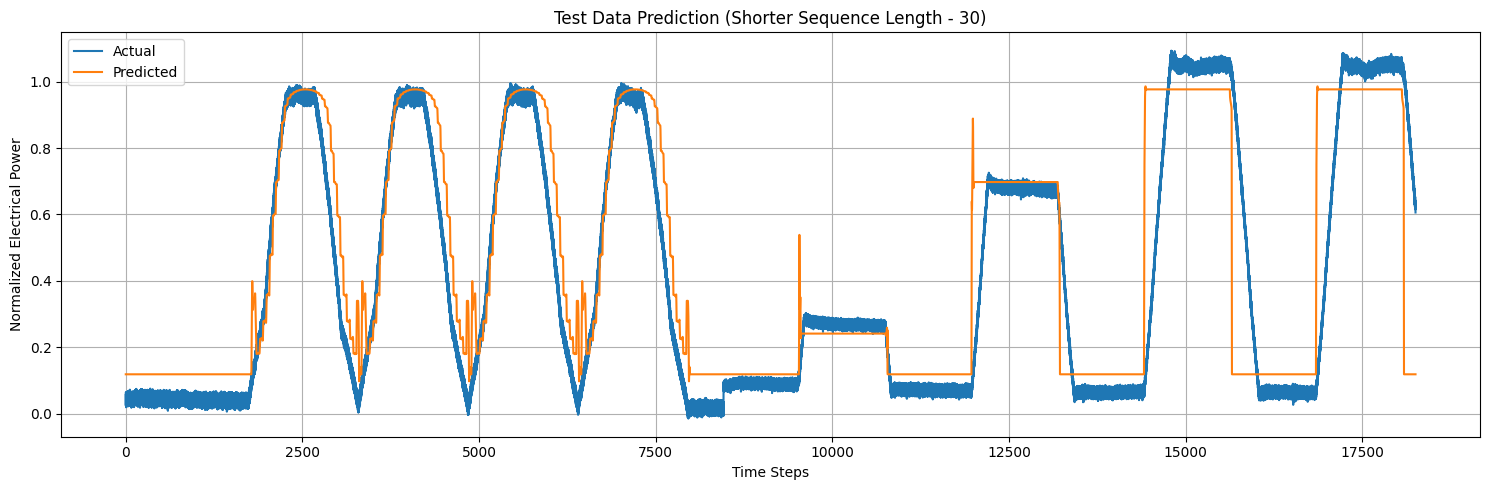

In [ ]:
# Ablation Study: Shorter Sequence Length (30 timesteps)
# File: shorter_seq_len.ipynb

import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------------------
# Step 1: Load and preprocess train data
# --------------------------------------
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
train_extract_path = os.path.join(dataset_path, 'train_extracted')

if not os.path.exists(train_extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)

csv_files = [os.path.join(root, file)
             for root, _, files in os.walk(train_extract_path)
             for file in files if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    dataframes.append(df)

train_df = pd.concat(dataframes, ignore_index=True)
exp_df = train_df[train_df['experiment'] == 'ex_23'].copy()

# Normalize
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()
exp_df['input_voltage_norm'] = scaler_input.fit_transform(exp_df[['input_voltage']])
exp_df['el_power_norm'] = scaler_output.fit_transform(exp_df[['el_power']])

# --------------------------------------
# Step 2: Sequence generation with shorter window (30)
# --------------------------------------
def create_sequences(df, input_col='input_voltage_norm', target_col='el_power_norm', seq_len=30):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[input_col].iloc[i:i+seq_len].values)
        y.append(df[target_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(exp_df, seq_len=sequence_length)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# --------------------------------------
# Step 3: PyTorch Dataset and LSTM Model
# --------------------------------------
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TurbineDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TurbineDataset(X_val, y_val), batch_size=64, shuffle=False)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

model = LSTMRegressor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------------------
# Step 4: Training
# --------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.5f}, Val Loss={val_losses[-1]:.5f}")

# --------------------------------------
# Step 5: Evaluate on Test Set
# --------------------------------------
test_zip_path = os.path.join(dataset_path, 'test.zip')
test_extract_path = os.path.join(dataset_path, 'test_extracted')

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)

test_csv_files = [os.path.join(root, file)
                  for root, _, files in os.walk(test_extract_path)
                  for file in files if file.endswith('.csv')]

test_dfs = []
for file in test_csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)
test_df['input_voltage_norm'] = scaler_input.transform(test_df[['input_voltage']])
test_df['el_power_norm'] = scaler_output.transform(test_df[['el_power']])

X_test, y_test = create_sequences(test_df, seq_len=sequence_length)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE (Shorter Sequence Length): {rmse_test:.5f}")

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Test Data Prediction (Shorter Sequence Length - 30)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Electrical Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ablation: Simpler LSTM

Epoch 1: Train Loss=0.05890, Val Loss=0.03422
Epoch 2: Train Loss=0.02412, Val Loss=0.03243
Epoch 3: Train Loss=0.02191, Val Loss=0.02961
Epoch 4: Train Loss=0.02001, Val Loss=0.02993
Epoch 5: Train Loss=0.02002, Val Loss=0.02626
Epoch 6: Train Loss=0.01868, Val Loss=0.02731
Epoch 7: Train Loss=0.01813, Val Loss=0.03070
Epoch 8: Train Loss=0.01767, Val Loss=0.02420
Epoch 9: Train Loss=0.01695, Val Loss=0.02341
Epoch 10: Train Loss=0.01630, Val Loss=0.02298
Epoch 11: Train Loss=0.01760, Val Loss=0.02299
Epoch 12: Train Loss=0.01633, Val Loss=0.02967
Epoch 13: Train Loss=0.01640, Val Loss=0.02272
Epoch 14: Train Loss=0.01541, Val Loss=0.02236
Epoch 15: Train Loss=0.01537, Val Loss=0.02288
Epoch 16: Train Loss=0.01659, Val Loss=0.02219
Epoch 17: Train Loss=0.01529, Val Loss=0.02166
Epoch 18: Train Loss=0.01494, Val Loss=0.02165
Epoch 19: Train Loss=0.01494, Val Loss=0.02175
Epoch 20: Train Loss=0.01489, Val Loss=0.02172
Epoch 21: Train Loss=0.01484, Val Loss=0.02172
Epoch 22: Train Loss=0

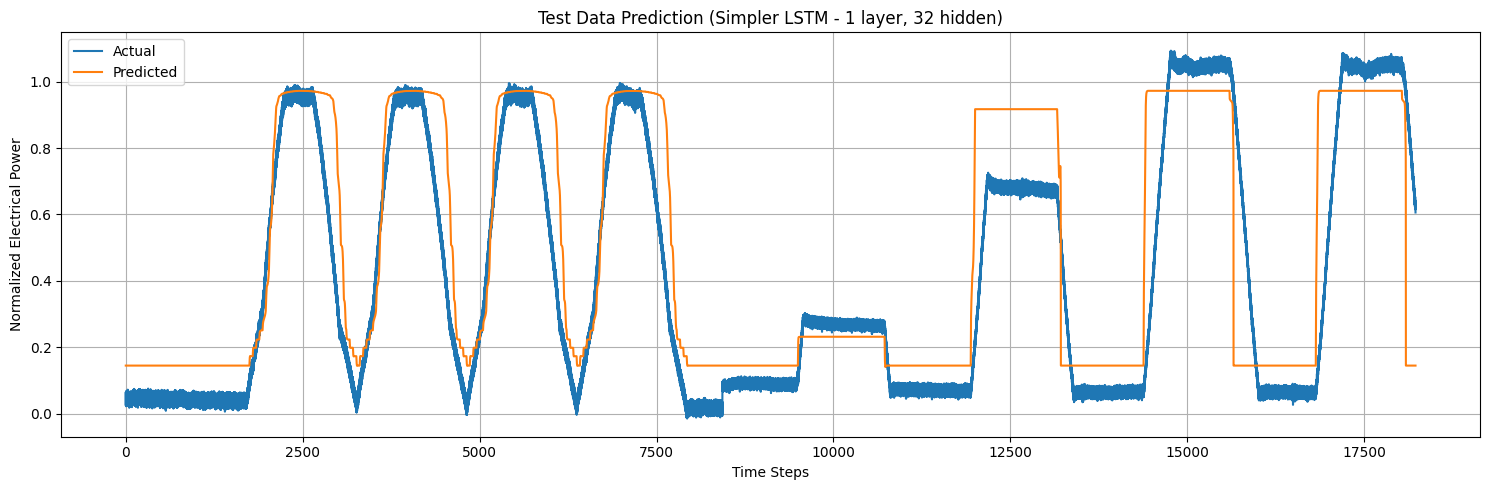

In [ ]:
# Ablation Study: Simpler LSTM (1 layer, 32 hidden units)
# File: simpler_lstm.ipynb

import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------------------
# Step 1: Load and preprocess train data
# --------------------------------------
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
train_extract_path = os.path.join(dataset_path, 'train_extracted')

if not os.path.exists(train_extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)

csv_files = [os.path.join(root, file)
             for root, _, files in os.walk(train_extract_path)
             for file in files if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    dataframes.append(df)

train_df = pd.concat(dataframes, ignore_index=True)
exp_df = train_df[train_df['experiment'] == 'ex_23'].copy()

# Normalize
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()
exp_df['input_voltage_norm'] = scaler_input.fit_transform(exp_df[['input_voltage']])
exp_df['el_power_norm'] = scaler_output.fit_transform(exp_df[['el_power']])

# --------------------------------------
# Step 2: Sequence generation
# --------------------------------------
def create_sequences(df, input_col='input_voltage_norm', target_col='el_power_norm', seq_len=60):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[input_col].iloc[i:i+seq_len].values)
        y.append(df[target_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(exp_df, seq_len=sequence_length)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# --------------------------------------
# Step 3: PyTorch Dataset and Simplified LSTM
# --------------------------------------
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TurbineDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TurbineDataset(X_val, y_val), batch_size=64, shuffle=False)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

model = LSTMRegressor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------------------
# Step 4: Training
# --------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.5f}, Val Loss={val_losses[-1]:.5f}")

# --------------------------------------
# Step 5: Evaluate on Test Set
# --------------------------------------
test_zip_path = os.path.join(dataset_path, 'test.zip')
test_extract_path = os.path.join(dataset_path, 'test_extracted')

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)

test_csv_files = [os.path.join(root, file)
                  for root, _, files in os.walk(test_extract_path)
                  for file in files if file.endswith('.csv')]

test_dfs = []
for file in test_csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)
test_df['input_voltage_norm'] = scaler_input.transform(test_df[['input_voltage']])
test_df['el_power_norm'] = scaler_output.transform(test_df[['el_power']])

X_test, y_test = create_sequences(test_df, seq_len=sequence_length)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE (Simpler LSTM - 1 layer, 32 units): {rmse_test:.5f}")

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Test Data Prediction (Simpler LSTM - 1 layer, 32 hidden)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Electrical Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
